# 0. Импорт библиотек

In [125]:
import pandas as pd
import numpy as np
from math import sqrt
from collections import defaultdict
from sklearn.model_selection import train_test_split

# 1. Сборка датасета, разбиение на train test

In [290]:
ratings = pd.read_csv('restaurant_data/rating_final.csv')

In [135]:
ratings.columns

Index(['userID', 'placeID', 'rating', 'food_rating', 'service_rating'], dtype='object')

In [137]:
# Выбираем столбец рейтинга (rating) как основную целевую переменную.
print(f'Общее количество уникальных оценок: {len(ratings)}')
print(f'Количество уникальных пользователей: {ratings['userID'].nunique()}')
print(f'Количество уникальных ресторанов: {ratings['placeID'].nunique()}')

Общее количество уникальных оценок: 1161
Количество уникальных пользователей: 138
Количество уникальных ресторанов: 130


In [139]:
ratings.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [141]:
train_data, test_data = train_test_split(
    ratings, 
    test_size=0.3, 
    random_state=42)

print(f'Размер тренировочной выборки: {len(train_data)}')
print(f'Размер тестовой выборки: {len(test_data)}')

Размер тренировочной выборки: 812
Размер тестовой выборки: 349


# 2. Baseline SVD

In [143]:
unique_users = ratings['userID'].unique()
unique_places = ratings['placeID'].unique()

user_id_dict = {user_id: i for i, user_id in enumerate(unique_users)}
place_id_dict = {place_id: i for i, place_id in enumerate(unique_places)}

n_users = len(unique_users)
n_places = len(unique_places)

train_data_indexed = train_data.copy()
train_data_indexed['u_idx'] = train_data_indexed['userID'].map(user_id_dict) # добавлены индексы в трейн
train_data_indexed['i_idx'] = train_data_indexed['placeID'].map(place_id_dict)
train_data_list = train_data_indexed[['u_idx', 'i_idx', 'rating']].to_numpy()

print(f'Пользователей (U): {n_users}, Ресторанов (I): {n_places}')

Пользователей (U): 138, Ресторанов (I): 130


## Обучение базового алгоритма с помощью SGD

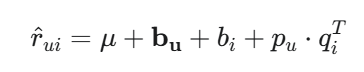
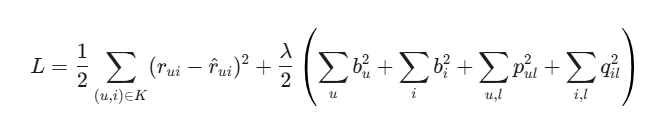

In [145]:
K = 10
alpha = 0.01
lambda_reg = 0.1
n_epochs = 25

P = np.random.normal(0, 0.1, (n_users, K)) # Пользовательские факторы
Q = np.random.normal(0, 0.1, (n_places, K)) # Факторы ресторанов
b_u = np.zeros(n_users) # Смещения пользователей
b_i = np.zeros(n_places) # Смещения ресторанов
mu = train_data['rating'].mean() # Глобальное среднее

print(f'Глобальный средний рейтинг (μ): {mu:.4f}')
print(f'Начало обучения SVD (K={K}, λ={lambda_reg})')

Глобальный средний рейтинг (μ): 1.2094
Начало обучения SVD (K=10, λ=0.1)


In [147]:
for epoch in range(n_epochs):
    np.random.shuffle(train_data_list)
    count = 0
    
    for u_idx, i_idx, rating in train_data_list:
        
        u_idx = int(u_idx)
        i_idx = int(i_idx)
        
        # 1. Предсказание: r_hat = mu + b_u + b_i + q_i^T * p_u
        r_hat = mu + b_u[u_idx] + b_i[i_idx] + np.dot(Q[i_idx, :], P[u_idx, :])
        r_hat = np.clip(r_hat, 0, 2) # Ограничиваем диапазон оценок [0, 2]

        error = rating - r_hat
        count += 1

        b_u[u_idx] += alpha * (error - lambda_reg * b_u[u_idx])
        b_i[i_idx] += alpha * (error - lambda_reg * b_i[i_idx])

        p_u_old = P[u_idx, :].copy()
        q_i_old = Q[i_idx, :].copy()
        
        P[u_idx, :] += alpha * (error * q_i_old - lambda_reg * p_u_old)
        Q[i_idx, :] += alpha * (error * p_u_old - lambda_reg * q_i_old)

print('Обучение Базовой SVD завершено. Параметры P, Q, b_u, b_i сохранены.')

Обучение Базовой SVD завершено. Параметры P, Q, b_u, b_i сохранены.


In [149]:
def predict_svd_base(user_id, place_id):
    if user_id not in user_id_dict or place_id not in place_id_dict:
        return mu 
        
    u_idx = user_id_dict[user_id]
    i_idx = place_id_dict[place_id]
    prediction = mu + b_u[u_idx] + b_i[i_idx] + np.dot(Q[i_idx, :], P[u_idx, :])
    
    return np.clip(prediction, 0, 2)

## Расчет MAP@50 для базового алгоритма

In [208]:
RELEVANCE_THRESHOLD = 2
K_METRIC = 50

In [151]:
test_user_ratings = test_data.groupby('userID').apply(
    lambda x: dict(zip(x['placeID'], x['rating']))
).to_dict()

C:\Users\User\AppData\Local\Temp\ipykernel_21948\2516287565.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_user_ratings = test_data.groupby('userID').apply(


In [153]:
def calculate_average_precision_at_k(recommended_items, relevant_items, k):
    if not relevant_items:
        return 0.0
    hits = 0
    sum_precisions = 0
    
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            hits += 1
            precision_at_i = hits / (i + 1.0)
            sum_precisions += precision_at_i
            
    return sum_precisions / min(len(relevant_items), k) if hits > 0 else 0.0

In [155]:
all_ap_scores_base = []
all_places = ratings['placeID'].unique()

for user_id, ratings_dict in test_user_ratings.items():
    
    user_predictions = {}
    rated_places_train = set(train_data[train_data['userID'] == user_id]['placeID'])

    for place_id in all_places:
        if place_id not in rated_places_train: # пользователь не оценивал эти места в трейне
            predicted_rating = predict_svd_base(user_id, place_id) 
            user_predictions[place_id] = predicted_rating

    recommended_items = sorted( # ранжируем!
        user_predictions, 
        key=user_predictions.get, 
        reverse=True
    )[:K_METRIC]

    relevant_items = [item for item, score in ratings_dict.items() if score >= RELEVANCE_THRESHOLD] # берем те, которые подошли по порогу релевантности
    all_ap_scores_base.append(calculate_average_precision_at_k(recommended_items, relevant_items, K_METRIC))

MAP_BASE_SVD = np.mean(all_ap_scores_base)
print(f'MAP@50 для Базовой SVD (Контроль): {MAP_BASE_SVD:.4f}')

MAP@50 для Базовой SVD (Контроль): 0.0323


# 3. Постфильтрация по местоположению

в качестве контекста решил использовать местоположение клиента по отношении к ресторану

## Расчет расстояния по координатам

In [157]:
user_profile_df = pd.read_csv('restaurant_data/userprofile.csv')
places_df = pd.read_csv('restaurant_data/geoplaces2.csv', encoding='latin-1')

In [159]:
user_profile_df.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


In [161]:
R_EARTH = 6371 # Радиус Земли в км
DEG_TO_RAD = np.pi / 180.0
MAX_DISTANCE_KM = 2.0 

In [163]:
# формула Гаверсинуса
def haversine_distance(lat1, lon1, lat2, lon2):
    
    # Конвертация градусов в радианы
    lat1_rad, lon1_rad = lat1 * DEG_TO_RAD, lon1 * DEG_TO_RAD
    lat2_rad, lon2_rad = lat2 * DEG_TO_RAD, lon2 * DEG_TO_RAD
    
    dLat = lat2_rad - lat1_rad
    dLon = lon2_rad - lon1_rad

    a = np.sin(dLat / 2) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(dLon / 2) ** 2
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R_EARTH * c

In [165]:
user_profile_df = user_profile_df[['userID', 'latitude', 'longitude']].rename(
    columns={'latitude': 'u_lat', 'longitude': 'u_lon'}
)
user_loc_dict = user_profile_df.set_index('userID').to_dict('index')

place_coords_df = places_df[['placeID', 'latitude', 'longitude']].drop_duplicates(subset=['placeID'])
place_coords_dict = place_coords_df.set_index('placeID')[['latitude', 'longitude']].to_dict('index')

test_user_ratings = test_data.groupby('userID').apply(
    lambda x: dict(zip(x['placeID'], x['rating']))
).to_dict()
all_places = ratings['placeID'].unique()

C:\Users\User\AppData\Local\Temp\ipykernel_21948\3952733740.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_user_ratings = test_data.groupby('userID').apply(


In [167]:
all_ap_scores_post_filter = []

for user_id, ratings_dict in test_user_ratings.items():
    if user_id not in user_avg_loc_dict: 
        continue
        
    # Получаем контекст пользователя
    user_context = user_avg_loc_dict[user_id]
    u_avg_lat = user_context['u_avg_lat']
    u_avg_lon = user_context['u_avg_lon']

    user_predictions_post_filter = {}
    rated_places_train = set(train_data[train_data['userID'] == user_id]['placeID'])
    
    for place_id in all_places:
        # Пропускаем места, которые пользователь уже оценил в train
        if place_id not in rated_places_train:

            place_coords = place_coords_dict.get(place_id)
            if not place_coords: continue # Если координат нет, пропускаем
            
            p_lat = place_coords['latitude']
            p_lon = place_coords['longitude']
            distance = haversine_distance(u_avg_lat, u_avg_lon, p_lat, p_lon) # ищем расстояние от юзера до ресторана
            
            if distance <= MAX_DISTANCE_KM:
                predicted_rating = predict_svd_base(user_id, place_id) 
                if not np.isnan(predicted_rating):
                    user_predictions_post_filter[place_id] = predicted_rating

    # рассчит метрику AP@50
    recommended_items = sorted(
        user_predictions_post_filter, 
        key=user_predictions_post_filter.get, 
        reverse=True
    )[:K_METRIC]

    relevant_items = [item for item, score in ratings_dict.items() if score >= RELEVANCE_THRESHOLD]
    
    all_ap_scores_post_filter.append(calculate_average_precision_at_k(recommended_items, relevant_items, K_METRIC))

MAP_POST_FILTER = np.mean(all_ap_scores_post_filter)
print(f'MAP@50 для SVD с постфильтрацией (радиус {MAX_DISTANCE_KM} км): {MAP_POST_FILTER:.4f}')

MAP@50 для SVD с постфильтрацией (радиус 2.0 км): 0.1243


In [169]:
print(f'с применением постфильтрации MAP@50 выросла в {MAP_POST_FILTER/MAP_BASE_SVD:.3f} раз(а)')

с применением постфильтрации MAP@50 выросла в 3.847 раз(а)


# 4. Контекстное моделирование

## 4.1 Контекст - любимая кухня

In [171]:
user_cuisine_df = pd.read_csv('restaurant_data/usercuisine.csv')
chefmoz_cuisine_df = pd.read_csv('restaurant_data/chefmozcuisine.csv')

# ключ: userID, Значение: любимые кухни
user_cuisine_dict = defaultdict(set)
for index, row in user_cuisine_df.iterrows():
    user_cuisine_dict[row['userID']].add(row['Rcuisine'])
    
# Ключ: placeID, Значение: Множество кухонь, которые предлагает место
place_cuisine_dict = defaultdict(set)
for index, row in chefmoz_cuisine_df.iterrows():
    place_cuisine_dict[row['placeID']].add(row['Rcuisine'])

In [178]:
def predict_svd_c(user_id, place_id):
    # базовое предсказание
    predicted_rating = predict_svd_base(user_id, place_id) 

    if np.isnan(predicted_rating):
        return np.nan
    # контекстное смещение
    user_cuisines = user_cuisine_dict.get(user_id, set())
    place_cuisines = place_cuisine_dict.get(place_id, set())
    matching_cuisines = user_cuisines.intersection(place_cuisines)
    context_bias = 0.0
    
    if matching_cuisines:
        context_bias = CONTEXT_WEIGHT_CUISINE
    else:
        context_bias = 0.0 # если нет совпадений, то никак не меняем баес
        
    final_prediction = predicted_rating + context_bias
    
    return final_prediction

In [284]:
CONTEXT_WEIGHT_CUISINE = 5
all_ap_scores_svd_c = []

for user_id, ratings_dict in test_user_ratings.items():
    
    user_predictions_svd_c = {}
    rated_places_train = set(train_data[train_data['userID'] == user_id]['placeID'])
    
    for place_id in all_places:
        if place_id not in rated_places_train:

            predicted_rating = predict_svd_c(user_id, place_id) # SVD-c !!!
            
            if not np.isnan(predicted_rating):
                user_predictions_svd_c[place_id] = predicted_rating

    # Ранжирование и Расчет AP
    recommended_items = sorted(
        user_predictions_svd_c, 
        key=user_predictions_svd_c.get, 
        reverse=True
    )[:K_METRIC]
    
    relevant_items = [item for item, score in ratings_dict.items() if score >= RELEVANCE_THRESHOLD]
    
    all_ap_scores_svd_c.append(calculate_average_precision_at_k(recommended_items, relevant_items, K_METRIC))

MAP_SVD_C = np.mean(all_ap_scores_svd_c)
print(f"MAP@50 для SVD с Контекстным Моделированием (Тип кухни, Bias={CONTEXT_WEIGHT_CUISINE}): {MAP_SVD_C:.4f}")

MAP@50 для SVD с Контекстным Моделированием (Тип кухни, Bias=5): 0.0213


Результаты хуже чем базовый алгоритм...

Значит очень много шума и предпочтения по кухням у пользователей из выборки весьма размытое.

## 4.2 Контекст - бюджет пользователя

In [202]:
user_profile_df = pd.read_csv('restaurant_data/userprofile.csv')
places_df = pd.read_csv('restaurant_data/geoplaces2.csv', encoding='latin-1')

In [204]:
# Словарь бюджета пользователя
user_budget_df = user_profile_df[['userID', 'budget']].drop_duplicates(subset=['userID'])
user_budget_dict = user_budget_df.set_index('userID')['budget'].to_dict()

# Словарь ценовой категории места
place_price_df = places_df[['placeID', 'price']].drop_duplicates(subset=['placeID'])
place_price_dict = place_price_df.set_index('placeID')['price'].to_dict()

In [272]:
CONTEXT_WEIGHT_BUDGET = 0.8

In [274]:
def predict_svd_c_budget(user_id, place_id):
    """
    Прогноз SVD с Контекстным Смещением (Budget Match)
    """
    
    # 1. Базовое предсказание SVD
    predicted_rating = predict_svd_base(user_id, place_id) 
    
    if np.isnan(predicted_rating):
        return np.nan

    # 2. Определение контекстного смещения (Budget Match Feature)
    user_budget = user_budget_dict.get(user_id)
    place_price = place_price_dict.get(place_id)
    
    context_bias = 0.0
    
    # ВАЖНОЕ ПРАВИЛО: Добавляем положительное смещение только при точном совпадении
    if user_budget is not None and place_price is not None:
        if user_budget == place_price:
            context_bias = CONTEXT_WEIGHT_BUDGET
        # Можно добавить штраф за сильное несовпадение (например, user='low', place='high'),
        # но для начала оставим только поощрение за совпадение.
        elif (user_budget == 'low' and place_price == 'high') or \
             (user_budget == 'high' and place_price == 'low'):
            context_bias = -0.5
        
    # 3. ФИНАЛЬНЫЙ ПРОГНОЗ: SVD + Контекст
    final_prediction = predicted_rating + context_bias
    
    return final_prediction

In [276]:
all_ap_scores_svd_c_budget = []

for user_id, ratings_dict in test_user_ratings.items():
    
    user_predictions_svd_c_budget = {}
    rated_places_train = set(train_data[train_data['userID'] == user_id]['placeID'])
    
    for place_id in all_places:
        if place_id not in rated_places_train:
            
            predicted_rating = predict_svd_c_budget(user_id, place_id) # SVD-c для бюджета!
            
            if not np.isnan(predicted_rating):
                user_predictions_svd_c_budget[place_id] = predicted_rating

    # Ранжирование и Расчет AP
    recommended_items = sorted(
        user_predictions_svd_c_budget, 
        key=user_predictions_svd_c_budget.get, 
        reverse=True
    )[:K_METRIC]
    
    relevant_items = [item for item, score in ratings_dict.items() if score >= RELEVANCE_THRESHOLD]
    
    all_ap_scores_svd_c_budget.append(calculate_average_precision_at_k(recommended_items, relevant_items, K_METRIC))

MAP_SVD_C_BUDGET = np.mean(all_ap_scores_svd_c_budget)
print(f"MAP@50 для SVD с Контекстным Моделированием (Бюджет, Bias={CONTEXT_WEIGHT_BUDGET}): {MAP_SVD_C_BUDGET:.4f}")

MAP@50 для SVD с Контекстным Моделированием (Бюджет, Bias=0.8): 0.0304


С разным исходным баесом все равно метрика хуже, чем в базовом алгоритме...

видимо, контекстное моделирование для этой задачи не очень применимо(

# 5. Сравнительный анализ и выводы

In [286]:
print(f'MAP@50 для Базовой SVD (Контроль): {MAP_BASE_SVD:.4f}')
print(f'MAP@50 для SVD с постфильтрацией (радиус {MAX_DISTANCE_KM} км): {MAP_POST_FILTER:.4f}')
print(f"MAP@50 для SVD с Контекстным Моделированием (Тип кухни, Bias={CONTEXT_WEIGHT_CUISINE}): {MAP_SVD_C:.4f}")
print(f"MAP@50 для SVD с Контекстным Моделированием (Бюджет, Bias={CONTEXT_WEIGHT_BUDGET}): {MAP_SVD_C_BUDGET:.4f}")

MAP@50 для Базовой SVD (Контроль): 0.0323
MAP@50 для SVD с постфильтрацией (радиус 2.0 км): 0.1243
MAP@50 для SVD с Контекстным Моделированием (Тип кухни, Bias=5): 0.0213
MAP@50 для SVD с Контекстным Моделированием (Бюджет, Bias=0.8): 0.0304


На базовом алгоритме метрика была весьма небольшой.

Первый подход - **постфильтирация** - увеличил MAP@50 почти в 4 раза. Это означает, что местоположение является очень важным контекстным признаком для решении задачи прогноза рейтинга ресторанов, выставленных пользователями.   

Для контекстного моделирования для разнообразия были взяты другие контекстные признаки: вид кухни и бюджет пользователя. К сожалению, оба контекста потерпели крах... в случае с кухнями результаты оказались даже хуже базового алгоритма, что говорит о "бесполезном" контексте, по крайней мере именно в этом методе.